In [72]:
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torch.utils.tensorboard import SummaryWriter






In [73]:
def create_curve(freq, ampl, freq_noise, ampl_noise, window_size):
    freq = random.gauss(freq, freq_noise) #add noise to frequency
    ampl = random.gauss(ampl, ampl_noise) #add noise to amplitude
    time = np.linspace(0, 10*np.pi, window_size)
    x = ampl*np.cos(freq*time)
    noise = np.random.normal(random.uniform(-1,0), random.uniform(0,1), window_size)
    x+=noise
    x = np.expand_dims(x, axis = 0) #expand to get 2d array (features, window length)
    x = np.expand_dims(x, axis = 0) #expand to get 3d array to store 2d elements
    #print(f"freq: {freq}, ampl:{ampl}")
    #plt.plot(time, x[0,0,:])
    #plt.show()
    
    return x

def create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size):
   
    X_data_class_1_domain_1 = np.empty((0,1,window_size))
    X_data_class_2_domain_1 = np.empty((0,1,window_size))
    X_data_class_1_domain_2 = np.empty((0,1,window_size))
    X_data_class_2_domain_2 = np.empty((0,1,window_size))
    
    for i in range(n):
        X_data_class_1_domain_1 = np.append(X_data_class_1_domain_1, create_curve(frequencies[0], amplitudes[0], freq_noise, ampl_noise, window_size), axis = 0) 
        X_data_class_2_domain_1 = np.append(X_data_class_2_domain_1, create_curve(frequencies[1], amplitudes[1], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_1_domain_2 = np.append(X_data_class_1_domain_2, create_curve(frequencies[2], amplitudes[2], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_2_domain_2 = np.append(X_data_class_2_domain_2, create_curve(frequencies[3], amplitudes[3], freq_noise, ampl_noise, window_size), axis = 0)
        print(f"Data loaded: {i+1}/{n}")
        #print(i)
        #print((X_data_class_1_domain_1))
        
    n_samples = np.shape(X_data_class_2_domain_1)[0]*2  
    
    y_data_class_1_domain_1 = np.asarray([0]*np.shape(X_data_class_1_domain_1)[0])
    y_data_class_2_domain_1 = np.asarray([1]*np.shape(X_data_class_2_domain_1)[0])
    y_data_class_1_domain_2 = np.asarray([0]*np.shape(X_data_class_1_domain_2)[0])
    y_data_class_2_domain_2 = np.asarray([1]*np.shape(X_data_class_2_domain_2)[0])
    
    X_data_source = np.concatenate((X_data_class_1_domain_1, X_data_class_2_domain_1), axis = 0)
    y_data_source = np.concatenate((y_data_class_1_domain_1, y_data_class_2_domain_1), axis = 0)
    X_data_target = np.concatenate((X_data_class_1_domain_2, X_data_class_2_domain_2), axis = 0)
    y_data_target = np.concatenate((y_data_class_1_domain_2, y_data_class_2_domain_2), axis = 0)
    
    
    X_data_source = torch.from_numpy(X_data_source)
    y_data_source = torch.from_numpy(y_data_source)
    X_data_target = torch.from_numpy(X_data_target)
    y_data_target = torch.from_numpy(y_data_target)
    
    return n_samples, X_data_source, y_data_source, X_data_target, y_data_target
"""
#TEST
frequencies = [1,4,1.4,3.6]
amplitudes = [6,2,5,4]
freq_noise = 0.3
ampl_noise = 2
window_size = 1000
n_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
"""

'\n#TEST\nfrequencies = [1,4,1.4,3.6]\namplitudes = [6,2,5,4]\nfreq_noise = 0.3\nampl_noise = 2\nwindow_size = 1000\nn_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)\n'

In [74]:
class Dataset_Dummy_Source_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.9,3.1]#[1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, self.x_data, self.y_data, _, _ = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class Dataset_Dummy_Target_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, _, _, self.x_data, self.y_data = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [ ]:
#dataloader

dataset_source = Dataset_Dummy_Source_Window()

# define train/val dimensions
train_size_source = int(0.8 * len(dataset_source))
validation_size_source = len(dataset_source) - train_size_source

training_dataset_source, validation_dataset_source = torch.utils.data.random_split(dataset_source, [train_size_source, validation_size_source])
batch_size = 64
train_loader_source = DataLoader(dataset=training_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_source = DataLoader(dataset=validation_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)





dataset_target = Dataset_Dummy_Target_Window()

# define train/val dimensions
train_size_target = int(0.8 * len(dataset_target))
validation_size_target = len(dataset_target) - train_size_target

training_dataset_target, validation_dataset_target = torch.utils.data.random_split(dataset_target, [train_size_target, validation_size_target])
batch_size = 64
train_loader_target = DataLoader(dataset=training_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_target = DataLoader(dataset=validation_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

source_loader = {}
source_loader["train"] = train_loader_source
source_loader["val"] = validation_loader_source

target_loader = {}
target_loader["test"] = train_loader_target
target_loader["val"] = validation_loader_target

Data loaded: 1/8000
Data loaded: 2/8000
Data loaded: 3/8000
Data loaded: 4/8000
Data loaded: 5/8000
Data loaded: 6/8000
Data loaded: 7/8000
Data loaded: 8/8000
Data loaded: 9/8000
Data loaded: 10/8000
Data loaded: 11/8000
Data loaded: 12/8000
Data loaded: 13/8000
Data loaded: 14/8000
Data loaded: 15/8000
Data loaded: 16/8000
Data loaded: 17/8000
Data loaded: 18/8000
Data loaded: 19/8000
Data loaded: 20/8000
Data loaded: 21/8000
Data loaded: 22/8000
Data loaded: 23/8000
Data loaded: 24/8000
Data loaded: 25/8000
Data loaded: 26/8000
Data loaded: 27/8000
Data loaded: 28/8000
Data loaded: 29/8000
Data loaded: 30/8000
Data loaded: 31/8000
Data loaded: 32/8000
Data loaded: 33/8000
Data loaded: 34/8000
Data loaded: 35/8000
Data loaded: 36/8000
Data loaded: 37/8000
Data loaded: 38/8000
Data loaded: 39/8000
Data loaded: 40/8000
Data loaded: 41/8000
Data loaded: 42/8000
Data loaded: 43/8000
Data loaded: 44/8000
Data loaded: 45/8000
Data loaded: 46/8000
Data loaded: 47/8000
Data loaded: 48/8000
D

Data loaded: 395/8000
Data loaded: 396/8000
Data loaded: 397/8000
Data loaded: 398/8000
Data loaded: 399/8000
Data loaded: 400/8000
Data loaded: 401/8000
Data loaded: 402/8000
Data loaded: 403/8000
Data loaded: 404/8000
Data loaded: 405/8000
Data loaded: 406/8000
Data loaded: 407/8000
Data loaded: 408/8000
Data loaded: 409/8000
Data loaded: 410/8000
Data loaded: 411/8000
Data loaded: 412/8000
Data loaded: 413/8000
Data loaded: 414/8000
Data loaded: 415/8000
Data loaded: 416/8000
Data loaded: 417/8000
Data loaded: 418/8000
Data loaded: 419/8000
Data loaded: 420/8000
Data loaded: 421/8000
Data loaded: 422/8000
Data loaded: 423/8000
Data loaded: 424/8000
Data loaded: 425/8000
Data loaded: 426/8000
Data loaded: 427/8000
Data loaded: 428/8000
Data loaded: 429/8000
Data loaded: 430/8000
Data loaded: 431/8000
Data loaded: 432/8000
Data loaded: 433/8000
Data loaded: 434/8000
Data loaded: 435/8000
Data loaded: 436/8000
Data loaded: 437/8000
Data loaded: 438/8000
Data loaded: 439/8000
Data loade

Data loaded: 771/8000
Data loaded: 772/8000
Data loaded: 773/8000
Data loaded: 774/8000
Data loaded: 775/8000
Data loaded: 776/8000
Data loaded: 777/8000
Data loaded: 778/8000
Data loaded: 779/8000
Data loaded: 780/8000
Data loaded: 781/8000
Data loaded: 782/8000
Data loaded: 783/8000
Data loaded: 784/8000
Data loaded: 785/8000
Data loaded: 786/8000
Data loaded: 787/8000
Data loaded: 788/8000
Data loaded: 789/8000
Data loaded: 790/8000
Data loaded: 791/8000
Data loaded: 792/8000
Data loaded: 793/8000
Data loaded: 794/8000
Data loaded: 795/8000
Data loaded: 796/8000
Data loaded: 797/8000
Data loaded: 798/8000
Data loaded: 799/8000
Data loaded: 800/8000
Data loaded: 801/8000
Data loaded: 802/8000
Data loaded: 803/8000
Data loaded: 804/8000
Data loaded: 805/8000
Data loaded: 806/8000
Data loaded: 807/8000
Data loaded: 808/8000
Data loaded: 809/8000
Data loaded: 810/8000
Data loaded: 811/8000
Data loaded: 812/8000
Data loaded: 813/8000
Data loaded: 814/8000
Data loaded: 815/8000
Data loade

Data loaded: 1142/8000
Data loaded: 1143/8000
Data loaded: 1144/8000
Data loaded: 1145/8000
Data loaded: 1146/8000
Data loaded: 1147/8000
Data loaded: 1148/8000
Data loaded: 1149/8000
Data loaded: 1150/8000
Data loaded: 1151/8000
Data loaded: 1152/8000
Data loaded: 1153/8000
Data loaded: 1154/8000
Data loaded: 1155/8000
Data loaded: 1156/8000
Data loaded: 1157/8000
Data loaded: 1158/8000
Data loaded: 1159/8000
Data loaded: 1160/8000
Data loaded: 1161/8000
Data loaded: 1162/8000
Data loaded: 1163/8000
Data loaded: 1164/8000
Data loaded: 1165/8000
Data loaded: 1166/8000
Data loaded: 1167/8000
Data loaded: 1168/8000
Data loaded: 1169/8000
Data loaded: 1170/8000
Data loaded: 1171/8000
Data loaded: 1172/8000
Data loaded: 1173/8000
Data loaded: 1174/8000
Data loaded: 1175/8000
Data loaded: 1176/8000
Data loaded: 1177/8000
Data loaded: 1178/8000
Data loaded: 1179/8000
Data loaded: 1180/8000
Data loaded: 1181/8000
Data loaded: 1182/8000
Data loaded: 1183/8000
Data loaded: 1184/8000
Data loaded

Data loaded: 1501/8000
Data loaded: 1502/8000
Data loaded: 1503/8000
Data loaded: 1504/8000
Data loaded: 1505/8000
Data loaded: 1506/8000
Data loaded: 1507/8000
Data loaded: 1508/8000
Data loaded: 1509/8000
Data loaded: 1510/8000
Data loaded: 1511/8000
Data loaded: 1512/8000
Data loaded: 1513/8000
Data loaded: 1514/8000
Data loaded: 1515/8000
Data loaded: 1516/8000
Data loaded: 1517/8000
Data loaded: 1518/8000
Data loaded: 1519/8000
Data loaded: 1520/8000
Data loaded: 1521/8000
Data loaded: 1522/8000
Data loaded: 1523/8000
Data loaded: 1524/8000
Data loaded: 1525/8000
Data loaded: 1526/8000
Data loaded: 1527/8000
Data loaded: 1528/8000
Data loaded: 1529/8000
Data loaded: 1530/8000
Data loaded: 1531/8000
Data loaded: 1532/8000
Data loaded: 1533/8000
Data loaded: 1534/8000
Data loaded: 1535/8000
Data loaded: 1536/8000
Data loaded: 1537/8000
Data loaded: 1538/8000
Data loaded: 1539/8000
Data loaded: 1540/8000
Data loaded: 1541/8000
Data loaded: 1542/8000
Data loaded: 1543/8000
Data loaded

Data loaded: 1859/8000
Data loaded: 1860/8000
Data loaded: 1861/8000
Data loaded: 1862/8000
Data loaded: 1863/8000
Data loaded: 1864/8000
Data loaded: 1865/8000
Data loaded: 1866/8000
Data loaded: 1867/8000
Data loaded: 1868/8000
Data loaded: 1869/8000
Data loaded: 1870/8000
Data loaded: 1871/8000
Data loaded: 1872/8000
Data loaded: 1873/8000
Data loaded: 1874/8000
Data loaded: 1875/8000
Data loaded: 1876/8000
Data loaded: 1877/8000
Data loaded: 1878/8000
Data loaded: 1879/8000
Data loaded: 1880/8000
Data loaded: 1881/8000
Data loaded: 1882/8000
Data loaded: 1883/8000
Data loaded: 1884/8000
Data loaded: 1885/8000
Data loaded: 1886/8000
Data loaded: 1887/8000
Data loaded: 1888/8000
Data loaded: 1889/8000
Data loaded: 1890/8000
Data loaded: 1891/8000
Data loaded: 1892/8000
Data loaded: 1893/8000
Data loaded: 1894/8000
Data loaded: 1895/8000
Data loaded: 1896/8000
Data loaded: 1897/8000
Data loaded: 1898/8000
Data loaded: 1899/8000
Data loaded: 1900/8000
Data loaded: 1901/8000
Data loaded

Data loaded: 2217/8000
Data loaded: 2218/8000
Data loaded: 2219/8000
Data loaded: 2220/8000
Data loaded: 2221/8000
Data loaded: 2222/8000
Data loaded: 2223/8000
Data loaded: 2224/8000
Data loaded: 2225/8000
Data loaded: 2226/8000
Data loaded: 2227/8000
Data loaded: 2228/8000
Data loaded: 2229/8000
Data loaded: 2230/8000
Data loaded: 2231/8000
Data loaded: 2232/8000
Data loaded: 2233/8000
Data loaded: 2234/8000
Data loaded: 2235/8000
Data loaded: 2236/8000
Data loaded: 2237/8000
Data loaded: 2238/8000
Data loaded: 2239/8000
Data loaded: 2240/8000
Data loaded: 2241/8000
Data loaded: 2242/8000
Data loaded: 2243/8000
Data loaded: 2244/8000
Data loaded: 2245/8000
Data loaded: 2246/8000
Data loaded: 2247/8000
Data loaded: 2248/8000
Data loaded: 2249/8000
Data loaded: 2250/8000
Data loaded: 2251/8000
Data loaded: 2252/8000
Data loaded: 2253/8000
Data loaded: 2254/8000
Data loaded: 2255/8000
Data loaded: 2256/8000
Data loaded: 2257/8000
Data loaded: 2258/8000
Data loaded: 2259/8000
Data loaded

Data loaded: 2575/8000
Data loaded: 2576/8000
Data loaded: 2577/8000
Data loaded: 2578/8000
Data loaded: 2579/8000
Data loaded: 2580/8000
Data loaded: 2581/8000
Data loaded: 2582/8000
Data loaded: 2583/8000
Data loaded: 2584/8000
Data loaded: 2585/8000
Data loaded: 2586/8000
Data loaded: 2587/8000
Data loaded: 2588/8000
Data loaded: 2589/8000
Data loaded: 2590/8000
Data loaded: 2591/8000
Data loaded: 2592/8000
Data loaded: 2593/8000
Data loaded: 2594/8000
Data loaded: 2595/8000
Data loaded: 2596/8000
Data loaded: 2597/8000
Data loaded: 2598/8000
Data loaded: 2599/8000
Data loaded: 2600/8000
Data loaded: 2601/8000
Data loaded: 2602/8000
Data loaded: 2603/8000
Data loaded: 2604/8000
Data loaded: 2605/8000
Data loaded: 2606/8000
Data loaded: 2607/8000
Data loaded: 2608/8000
Data loaded: 2609/8000
Data loaded: 2610/8000
Data loaded: 2611/8000
Data loaded: 2612/8000
Data loaded: 2613/8000
Data loaded: 2614/8000
Data loaded: 2615/8000
Data loaded: 2616/8000
Data loaded: 2617/8000
Data loaded

Data loaded: 2935/8000
Data loaded: 2936/8000
Data loaded: 2937/8000
Data loaded: 2938/8000
Data loaded: 2939/8000
Data loaded: 2940/8000
Data loaded: 2941/8000
Data loaded: 2942/8000
Data loaded: 2943/8000
Data loaded: 2944/8000
Data loaded: 2945/8000
Data loaded: 2946/8000
Data loaded: 2947/8000
Data loaded: 2948/8000
Data loaded: 2949/8000
Data loaded: 2950/8000
Data loaded: 2951/8000
Data loaded: 2952/8000
Data loaded: 2953/8000
Data loaded: 2954/8000
Data loaded: 2955/8000
Data loaded: 2956/8000
Data loaded: 2957/8000
Data loaded: 2958/8000
Data loaded: 2959/8000
Data loaded: 2960/8000
Data loaded: 2961/8000
Data loaded: 2962/8000
Data loaded: 2963/8000
Data loaded: 2964/8000
Data loaded: 2965/8000
Data loaded: 2966/8000
Data loaded: 2967/8000
Data loaded: 2968/8000
Data loaded: 2969/8000
Data loaded: 2970/8000
Data loaded: 2971/8000
Data loaded: 2972/8000
Data loaded: 2973/8000
Data loaded: 2974/8000
Data loaded: 2975/8000
Data loaded: 2976/8000
Data loaded: 2977/8000
Data loaded

Data loaded: 3293/8000
Data loaded: 3294/8000
Data loaded: 3295/8000
Data loaded: 3296/8000
Data loaded: 3297/8000
Data loaded: 3298/8000
Data loaded: 3299/8000
Data loaded: 3300/8000
Data loaded: 3301/8000
Data loaded: 3302/8000
Data loaded: 3303/8000
Data loaded: 3304/8000
Data loaded: 3305/8000
Data loaded: 3306/8000
Data loaded: 3307/8000
Data loaded: 3308/8000
Data loaded: 3309/8000
Data loaded: 3310/8000
Data loaded: 3311/8000
Data loaded: 3312/8000
Data loaded: 3313/8000
Data loaded: 3314/8000
Data loaded: 3315/8000
Data loaded: 3316/8000
Data loaded: 3317/8000
Data loaded: 3318/8000
Data loaded: 3319/8000
Data loaded: 3320/8000
Data loaded: 3321/8000
Data loaded: 3322/8000
Data loaded: 3323/8000
Data loaded: 3324/8000
Data loaded: 3325/8000
Data loaded: 3326/8000
Data loaded: 3327/8000
Data loaded: 3328/8000
Data loaded: 3329/8000
Data loaded: 3330/8000
Data loaded: 3331/8000
Data loaded: 3332/8000
Data loaded: 3333/8000
Data loaded: 3334/8000
Data loaded: 3335/8000
Data loaded

Data loaded: 3651/8000
Data loaded: 3652/8000
Data loaded: 3653/8000
Data loaded: 3654/8000
Data loaded: 3655/8000
Data loaded: 3656/8000
Data loaded: 3657/8000
Data loaded: 3658/8000
Data loaded: 3659/8000
Data loaded: 3660/8000
Data loaded: 3661/8000
Data loaded: 3662/8000
Data loaded: 3663/8000
Data loaded: 3664/8000
Data loaded: 3665/8000
Data loaded: 3666/8000
Data loaded: 3667/8000
Data loaded: 3668/8000
Data loaded: 3669/8000
Data loaded: 3670/8000
Data loaded: 3671/8000
Data loaded: 3672/8000
Data loaded: 3673/8000
Data loaded: 3674/8000
Data loaded: 3675/8000
Data loaded: 3676/8000
Data loaded: 3677/8000
Data loaded: 3678/8000
Data loaded: 3679/8000
Data loaded: 3680/8000
Data loaded: 3681/8000
Data loaded: 3682/8000
Data loaded: 3683/8000
Data loaded: 3684/8000
Data loaded: 3685/8000
Data loaded: 3686/8000
Data loaded: 3687/8000
Data loaded: 3688/8000
Data loaded: 3689/8000
Data loaded: 3690/8000
Data loaded: 3691/8000
Data loaded: 3692/8000
Data loaded: 3693/8000
Data loaded

Data loaded: 4008/8000
Data loaded: 4009/8000
Data loaded: 4010/8000
Data loaded: 4011/8000
Data loaded: 4012/8000
Data loaded: 4013/8000
Data loaded: 4014/8000
Data loaded: 4015/8000
Data loaded: 4016/8000
Data loaded: 4017/8000
Data loaded: 4018/8000
Data loaded: 4019/8000
Data loaded: 4020/8000
Data loaded: 4021/8000
Data loaded: 4022/8000
Data loaded: 4023/8000
Data loaded: 4024/8000
Data loaded: 4025/8000
Data loaded: 4026/8000
Data loaded: 4027/8000
Data loaded: 4028/8000
Data loaded: 4029/8000
Data loaded: 4030/8000
Data loaded: 4031/8000
Data loaded: 4032/8000
Data loaded: 4033/8000
Data loaded: 4034/8000
Data loaded: 4035/8000
Data loaded: 4036/8000
Data loaded: 4037/8000
Data loaded: 4038/8000
Data loaded: 4039/8000
Data loaded: 4040/8000
Data loaded: 4041/8000
Data loaded: 4042/8000
Data loaded: 4043/8000
Data loaded: 4044/8000
Data loaded: 4045/8000
Data loaded: 4046/8000
Data loaded: 4047/8000
Data loaded: 4048/8000
Data loaded: 4049/8000
Data loaded: 4050/8000
Data loaded

Data loaded: 4365/8000
Data loaded: 4366/8000
Data loaded: 4367/8000
Data loaded: 4368/8000
Data loaded: 4369/8000
Data loaded: 4370/8000
Data loaded: 4371/8000
Data loaded: 4372/8000
Data loaded: 4373/8000
Data loaded: 4374/8000
Data loaded: 4375/8000
Data loaded: 4376/8000
Data loaded: 4377/8000
Data loaded: 4378/8000
Data loaded: 4379/8000
Data loaded: 4380/8000
Data loaded: 4381/8000
Data loaded: 4382/8000
Data loaded: 4383/8000
Data loaded: 4384/8000
Data loaded: 4385/8000
Data loaded: 4386/8000
Data loaded: 4387/8000
Data loaded: 4388/8000
Data loaded: 4389/8000
Data loaded: 4390/8000
Data loaded: 4391/8000
Data loaded: 4392/8000
Data loaded: 4393/8000
Data loaded: 4394/8000
Data loaded: 4395/8000
Data loaded: 4396/8000
Data loaded: 4397/8000
Data loaded: 4398/8000
Data loaded: 4399/8000
Data loaded: 4400/8000
Data loaded: 4401/8000
Data loaded: 4402/8000
Data loaded: 4403/8000
Data loaded: 4404/8000
Data loaded: 4405/8000
Data loaded: 4406/8000
Data loaded: 4407/8000
Data loaded

In [66]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=100, stride=1)#input: 1000
        self.conv2 = nn.Conv1d(64,32,kernel_size=10, stride = 1, padding=1)#input: [(1000-100+2*0)/1]+1 = 901
        self.batch1 =nn.BatchNorm1d(32)#input: [(901-10+2*1)/1]+1 = 894
        self.conv3 = nn.Conv1d(32,32,kernel_size=5, stride = 1, padding=1) #input:894
        self.batch2 =nn.BatchNorm1d(32)#input: [(894-5+2*1)/1]+1 = 892
        #self.fc1 = nn.Linear(32*892, output_size)

    def forward(self, x):
        x = F.selu(self.conv1(x)) #conv1
        x = self.conv2(x) #conv2
        x = F.selu(self.batch1(x)) #batch1
        x = self.conv3(x) #conv3
        x = F.selu(self.batch2(x)) #batch2
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        #x = self.fc1(x) #linear1
        output = x
        
        return output

In [6]:
class CNN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN2, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 25, kernel_size=25, stride=1) #output: [(1000-25+2*0)/1]+1 = 976
        self.maxpool1 = nn.MaxPool1d(2, stride=2) #output: [((976+2*0-1*(2-1))-1)/2]+1= 488
        self.conv2 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(488-25+2*0)/1]+1 = 464
        self.maxpool2 = nn.MaxPool1d(2, stride=2) #output: [((464+2*0-1*(2-1)-1)/2]+1= 232
        self.conv3 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(232-25+2*0)/1]+1 = 208
        self.maxpool3 = nn.MaxPool1d(2, stride=2) #output: [(208+2*0-1*(2-1)-1)/2]+1= 104
        self.conv4 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(104-25+2*0)/1]+1 = 80 
        self.maxpool4 = nn.MaxPool1d(2, stride=2) #output: [(80+2*0-1*(2-1)-1)/2]+1= 40
        self.leakyrelu=torch.nn.LeakyReLU()
        #self.fc1 = nn.Linear(25*83, output_size)

    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.leakyrelu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.leakyrelu(self.conv3(x))
        x = self.maxpool3(x)
        x = self.leakyrelu(self.conv4(x))
        x = self.maxpool4(x)
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        output = x
        
        return output

In [67]:
input_size = 1
input_fc_size = 32*892 #25*40 
hidden_fc_size_1 = 100
hidden_fc_size_2 = 3
output_size = 2


classifier_layer_1 = nn.Linear(input_fc_size, hidden_fc_size_1)
classifier_layer_2 = nn.Linear(hidden_fc_size_1, hidden_fc_size_2)
classifier_layer_3 = nn.Linear(hidden_fc_size_2, output_size)



model = CNN(input_size, output_size)


print(model)

print(classifier_layer_1)

print(classifier_layer_2)

print(classifier_layer_3)

CNN(
  (conv1): Conv1d(1, 64, kernel_size=(100,), stride=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Linear(in_features=28544, out_features=100, bias=True)
Linear(in_features=100, out_features=3, bias=True)
Linear(in_features=3, out_features=2, bias=True)


In [68]:
#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss
        return loss

In [69]:
def forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, MMD_loss_flag, GAMMA_inter_class, GAMMA_intra_class):
        
        #Feature extraction
        outputs = model(data.float())

        #Classification
        x_src = classifier_layer_1(outputs[:batch_size, :])
        x_tar = classifier_layer_1(outputs[batch_size:, :])
        source_out = classifier_layer_2(x_src)
        target_out = classifier_layer_2(x_tar)
        source_pred = classifier_layer_3(source_out)
        target_pred = classifier_layer_3(target_out)
        
        #CE loss
        ce_loss = criterion(source_pred, labels_source)
        target_ce_loss = criterion(target_pred, labels_target)

        #collect information about labels, predictions to calculate accuracy
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0
        
        # list of latent space features for mmd and plot
        class_0_source_out = torch.empty((0,source_out.size()[1]))
        class_1_source_out = torch.empty((0,source_out.size()[1]))
        class_0_target_out = torch.empty((0,target_out.size()[1]))
        class_1_target_out = torch.empty((0,target_out.size()[1]))
        
        # list of latent space features for mmd
        class_0_source_x = torch.empty((0,x_src.size()[1]))
        class_1_source_x = torch.empty((0,x_src.size()[1]))
        class_0_target_x = torch.empty((0,x_tar.size()[1]))
        class_1_target_x = torch.empty((0,x_tar.size()[1]))
        
        
        #SOURCE iteration through batch
        for i in range(len(labels_source)):
            
            #get label and prediction
            label_source = labels_source[i]
            output_source = torch.argmax(source_pred[i])
            if label_source == output_source: #correct prediction
                n_correct_source+=1
            n_samples_source+=1
            
            #sort x_src and source_out depending on their classes
            if label_source == 0:
                class_0_source_out = torch.cat((class_0_source_out, torch.unsqueeze(source_out[i,:],0)),0)
                class_0_source_x = torch.cat((class_0_source_x, torch.unsqueeze(x_src[i,:],0)), 0)
            elif label_source == 1:
                class_1_source_out = torch.cat((class_1_source_out, torch.unsqueeze(source_out[i,:],0)), 0)
                class_1_source_x = torch.cat((class_1_source_x, torch.unsqueeze(x_src[i,:],0)), 0)
                
        acc_total_source = 100.0 * n_correct_source / n_samples_source #source accuracy
            
            
            
        #TARGET iteration through batch
        for i in range(len(labels_target)):
            
            #check correct prediction
            label_target = labels_target[i]
            output_target = torch.argmax(target_pred[i])#correct prediction
            if label_target == output_target:
                n_correct_target+=1
            n_samples_target+=1
            
            #sort x_tar and target_out depending on their classes
            if label_target == 0:
                class_0_target_out = torch.cat((class_0_target_out, torch.unsqueeze(target_out[i,:],0)),0)
                class_0_target_x = torch.cat((class_0_target_x, torch.unsqueeze(x_tar[i,:],0)), 0)
            elif label_target == 1:
                class_1_target_out = torch.cat((class_1_target_out, torch.unsqueeze(target_out[i,:], 0)), 0)
                class_1_target_x = torch.cat((class_1_target_x, torch.unsqueeze(x_tar[i,:], 0)), 0)
        
        

        #Interclass MMD loss
        
        #get number of elements to caclulcate mmd loss
        min_0_x = min(class_0_source_x.size()[0], class_0_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_1_target_x.size()[0])
        min_0_out = min(class_0_source_out.size()[0], class_0_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_1_target_out.size()[0])

        mmd_x_class_0_0 = MMD_loss.forward(class_0_source_x[:min_0_x,:],class_0_target_x[:min_0_x,:])
        mmd_x_class_1_1 = MMD_loss.forward(class_1_source_x[:min_1_x,:], class_1_target_x[:min_1_x,:])
        mmd_out_class_0_0 = MMD_loss.forward(class_0_source_out[:min_0_out,:], class_0_target_out[:min_0_out,:])
        mmd_out_class_1_1 = MMD_loss.forward(class_1_source_out[:min_1_out,:], class_1_target_out[:min_1_out,:])
        mmd_loss_inter_class = mmd_x_class_0_0 + mmd_x_class_1_1 + mmd_out_class_0_0 + mmd_out_class_1_1

        #Intraclass MMD loss
        
        #get number of elements to caclulcate mmd loss
        min_0_x = min(class_0_source_x.size()[0], class_1_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_0_target_x.size()[0])
        min_0_out = min(class_0_source_out.size()[0], class_1_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_0_target_out.size()[0])

        mmd_x_class_0_1+= MMD_loss.forward(class_0_source_x[:min_0_x,:], class_1_target_x[:min_0_x,:])
        mmd_x_class_1_0 = MMD_loss.forward(class_1_source_x[:min_1_x,:], class_0_target_x[:min_1_x,:])
        mmd_out_class_0_1 = MMD_loss.forward(class_0_source_out[:min_0_out,:], class_1_target_out[:min_0_out,:])
        mmd_out_class_1_0 = MMD_loss.forward(class_1_source_out[:min_1_out,:], class_0_target_out[:min_1_out,:])
        mmd_loss_intra_class = mmd_x_class_0_1 + mmd_x_class_1_0 + mmd_out_class_0_1 + mmd_out_class_1_0
        
        
        #total mmd loss
        mmd_loss = GAMMA_inter_class * mmd_loss_inter_class - GAMMA_intra_class * mmd_loss_intra_class
            
        
        acc_total_target = 100.0 * n_correct_target / n_samples_target #target accuracy

        
        return loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out
    
    
    


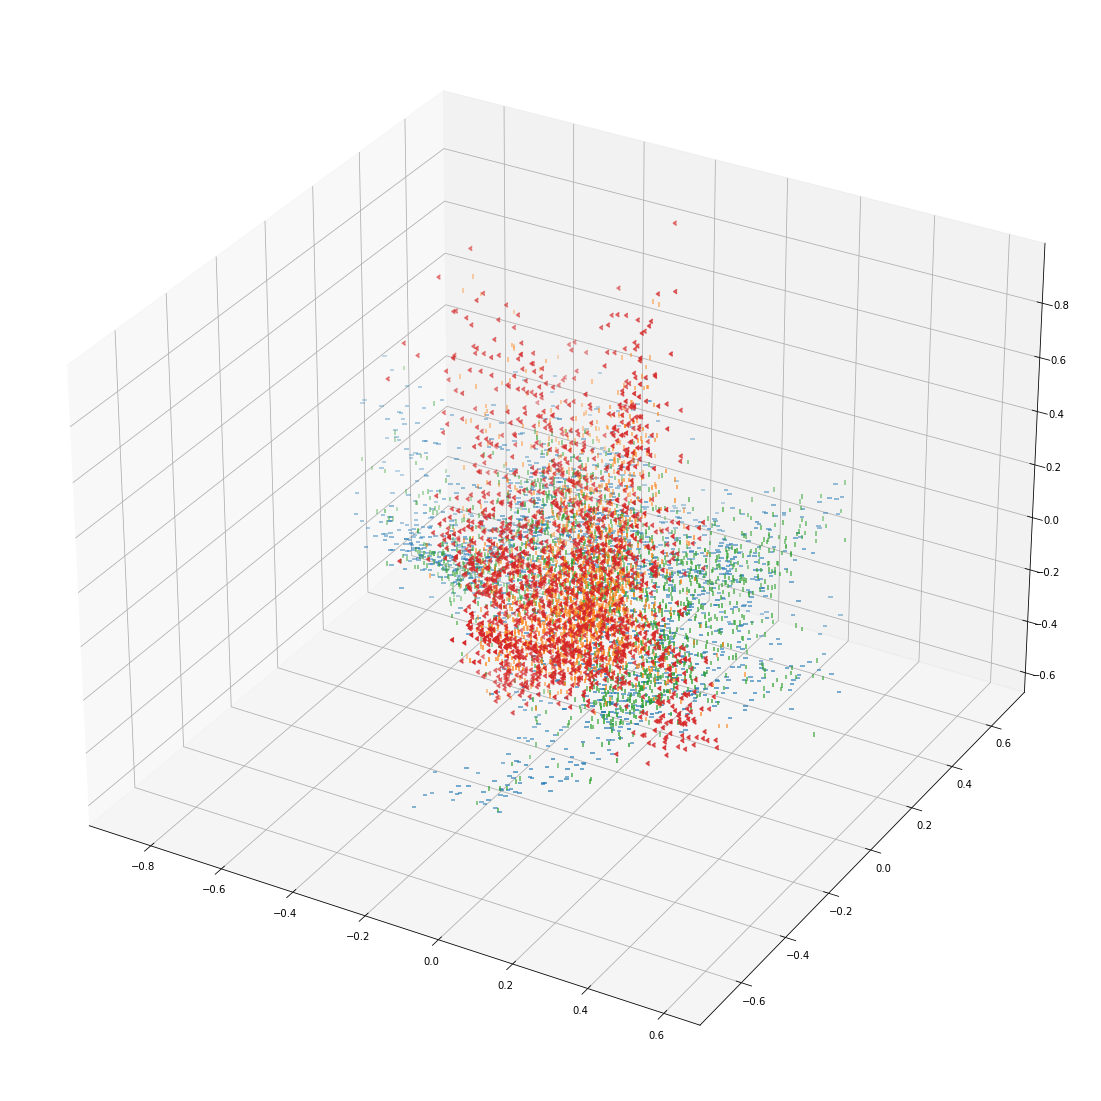

Epoch 1/10 successfull


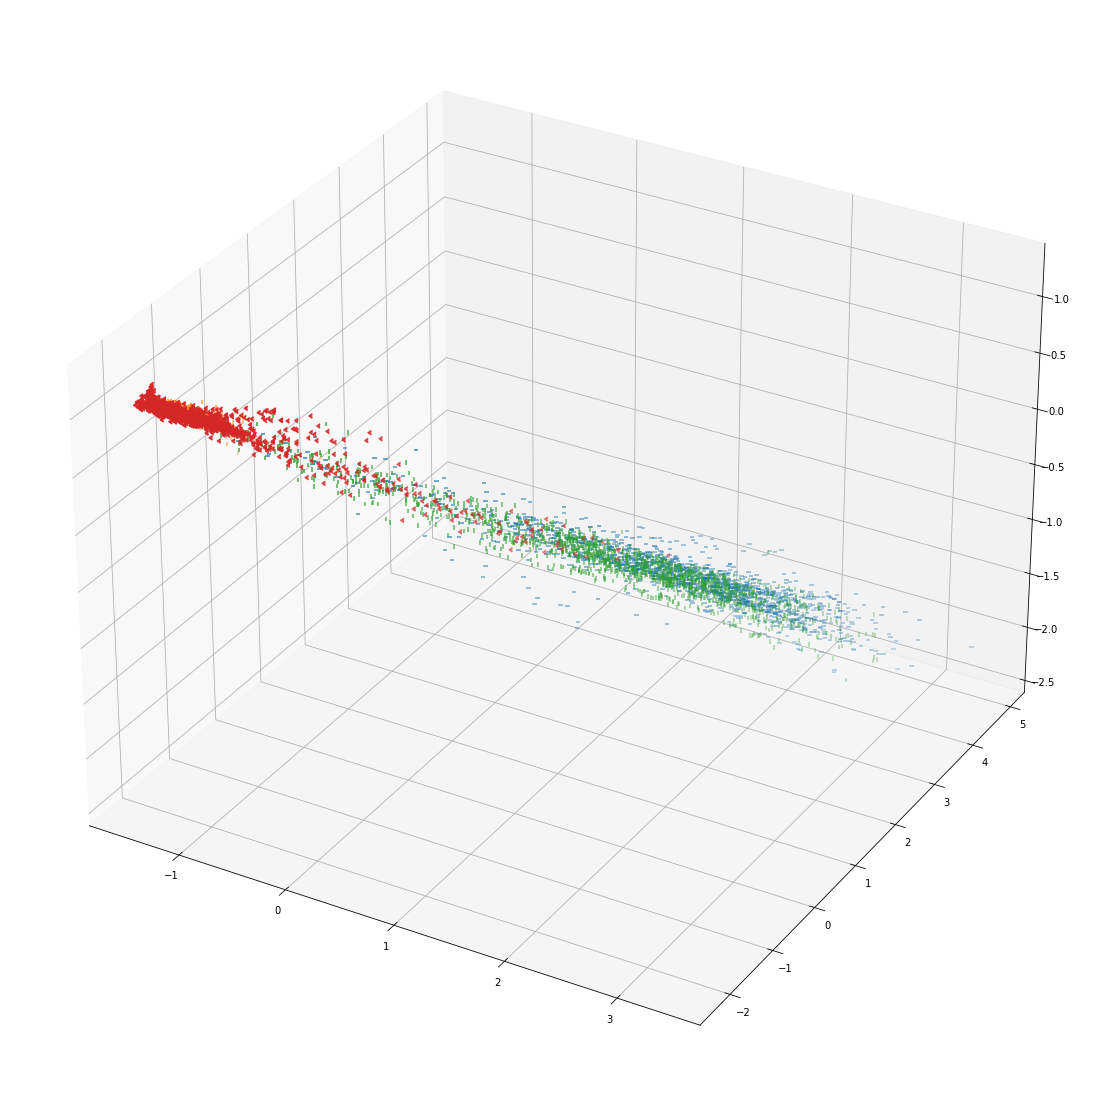

Epoch 2/10 successfull


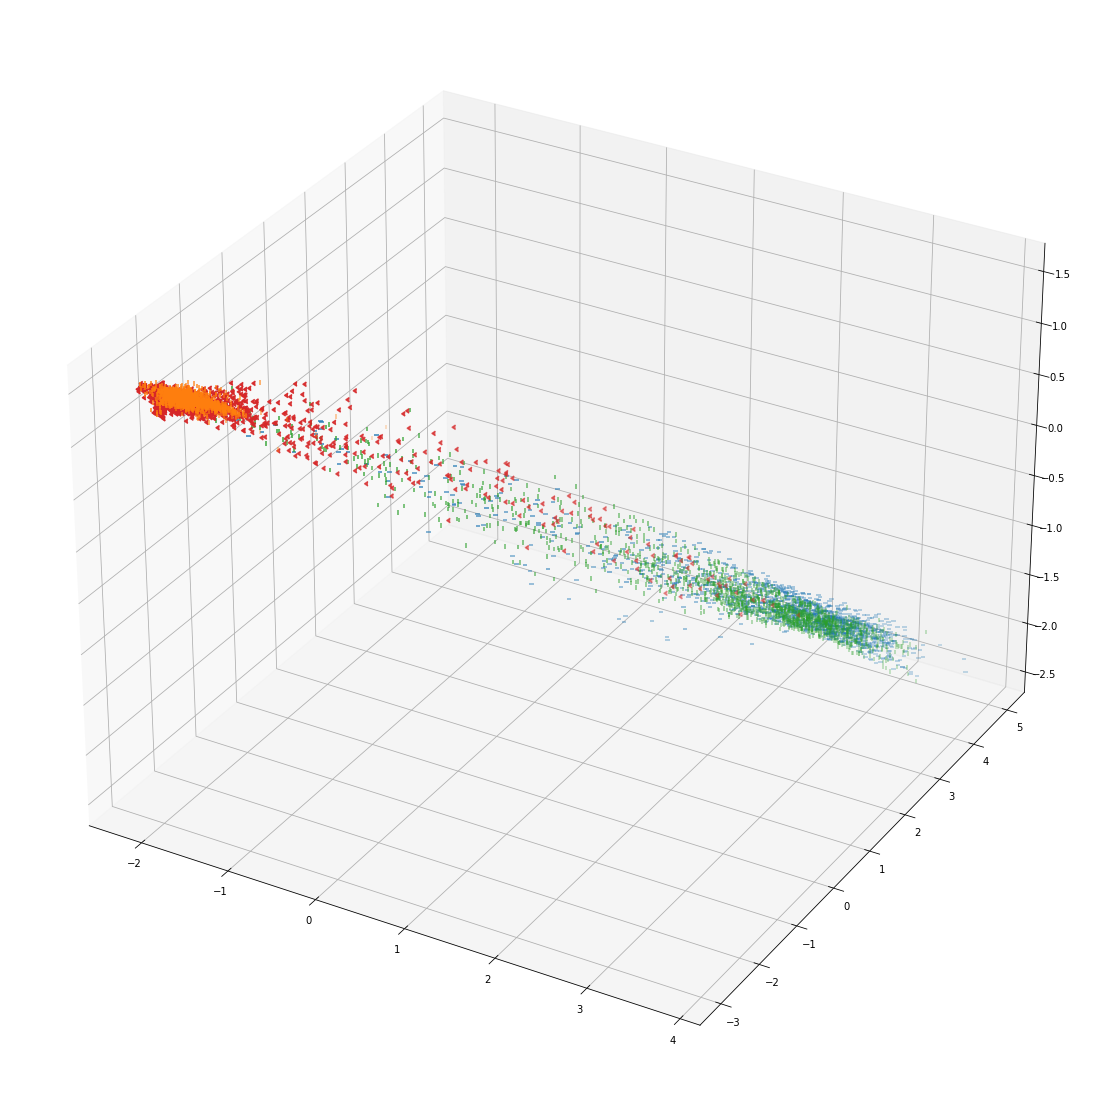

Epoch 3/10 successfull
Epoch 4/10 successfull


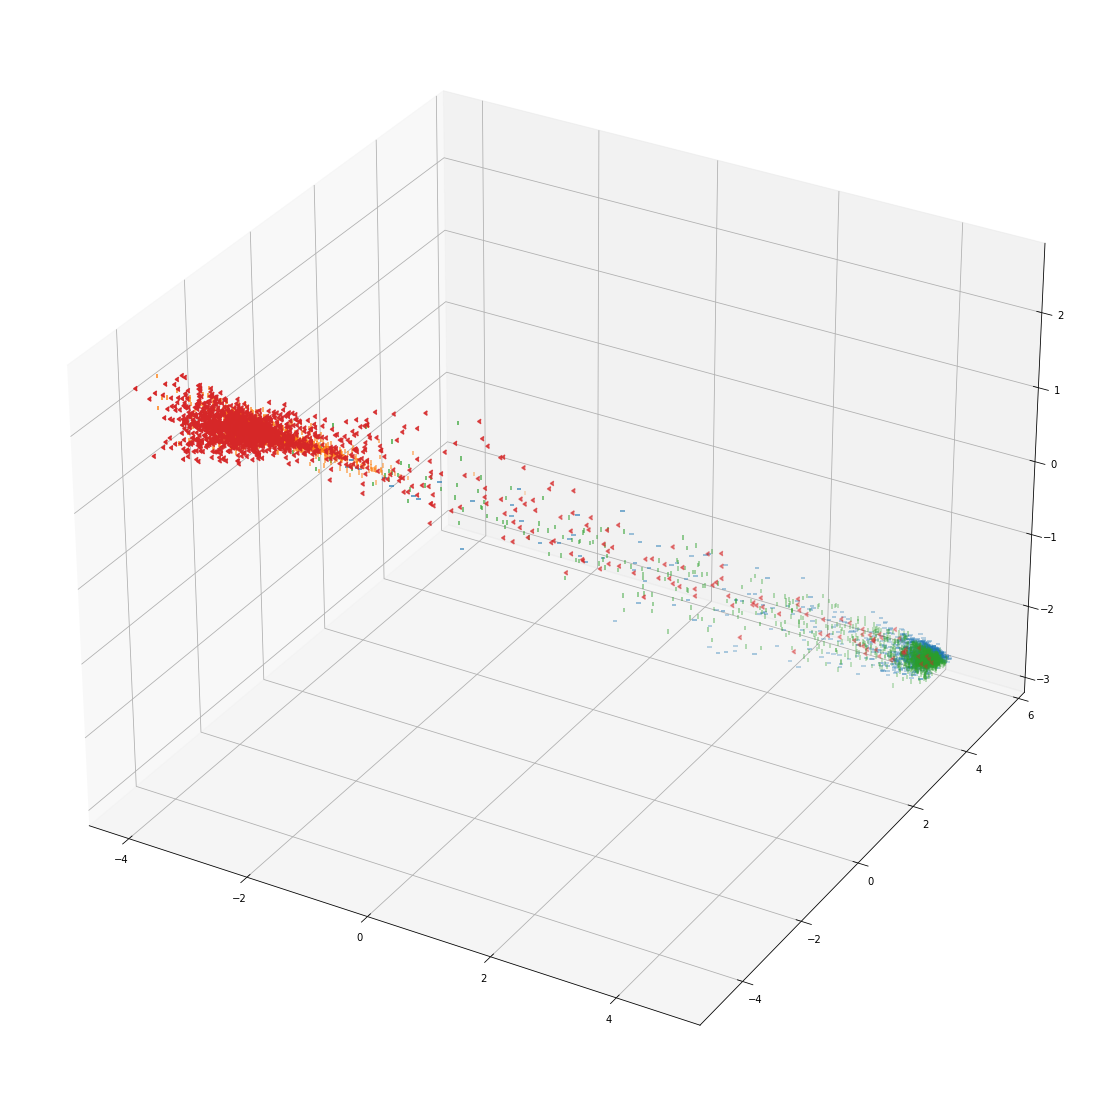

Epoch 5/10 successfull
Epoch 6/10 successfull


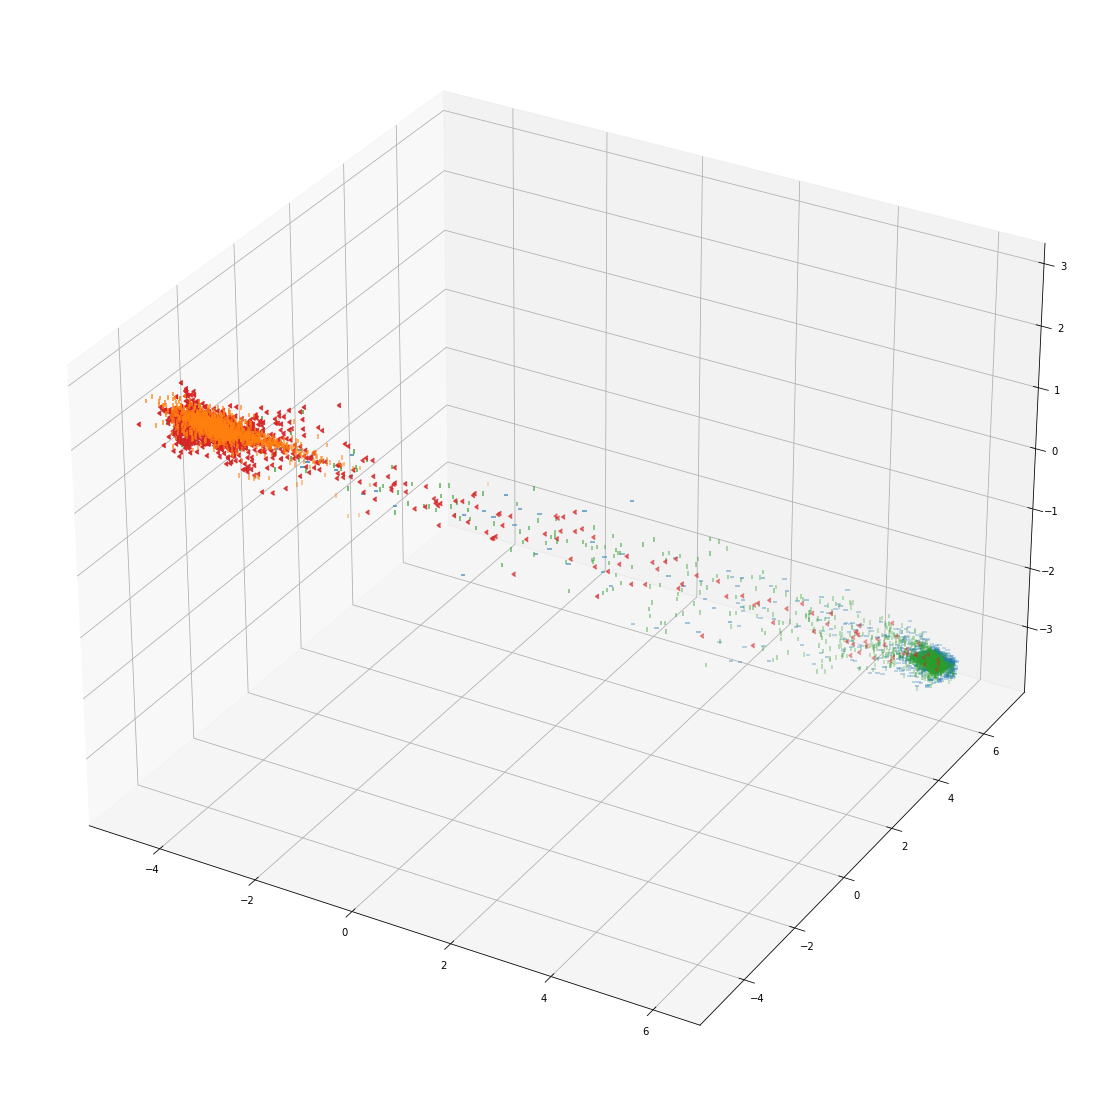

Epoch 7/10 successfull
Epoch 8/10 successfull
Epoch 9/10 successfull
Epoch 10/10 successfull


In [70]:
writer_graph = SummaryWriter('runs/Dataloader2/graph')
writer_train = SummaryWriter('runs/Dataloader2/train')
writer_val = SummaryWriter('runs/Dataloader2/val')
writer_test = SummaryWriter('runs/Dataloader2/test')
writer = {}
writer["train"] = writer_train
writer["val"] = writer_val
writer["test"] = writer_test


#define training params
num_epochs = 10
learning_rate = 0.1 #0.008
GAMMA_inter_class = 10
GAMMA_intra_class = 10
SIGMA = torch.tensor([2,4,8])  # default 1

#define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
MMD_loss = MMD_loss()
optimizer = torch.optim.SGD([model.parameters()], lr=learning_rate)



#dataloader for training and validation
dataloader_train = {}
dataloader_train["source"]=source_loader["train"]
dataloader_train["target"]=target_loader["test"]

#dataloader for testing
dataloader_val = {}
dataloader_val["source"]=source_loader["val"]
dataloader_val["target"]=target_loader["val"]

dataloaders = {}
dataloaders["train"] = dataloader_train
dataloaders["val"] = dataloader_val


#collect loss for each batch
loss_collected = 0
target_ce_loss_collected = 0
mmd_loss_collected = 0
loss_list = {}
loss_list['train']=[]
loss_list['val']=[]
loss_list['test'] = []

mmd_loss_list = []
target_ce_loss_list = []

#collect accuracy for each batch
acc_total_source_collected = 0
acc_total_target_collected = 0
accuracy_list={}
accuracy_list['train']=[]
accuracy_list['val']=[]
accuracy_list['test']=[]



phases = ["val", "train"]
# Train and Validate the model
for epoch in range(num_epochs):
    #plot mmd
    class_0_source_out_collect = torch.empty((0,3))
    class_1_source_out_collect = torch.empty((0,3))
    class_0_target_out_collect = torch.empty((0,3))
    class_1_target_out_collect = torch.empty((0,3))
    
    loss_collected = 0
    acc_collected = 0
    

    
    for phase in phases:
        iter_loader_source = iter(dataloaders[phase]["source"])
        iter_loader_target = iter(dataloaders[phase]["target"])
        
        MMD_loss_flag = True
        
        for i in range(len(dataloaders[phase]["source"])):
            
            ########Forward pass########
            data_source, labels_source = iter_loader_source.next() #batch_size number of windows and labels from source domain
            data_target, labels_target = iter_loader_target.next() #batch_size number of windows from target domain
            data = torch.cat((data_source, data_target), dim=0) #concat the windows to 2*batch_size number of windows

            batch_size = len(labels_source) #take length of shorter dataoader which is the one from source domain (reason:train, val split)
                        
            if phase == "val":
                
                model.train(False) #no training
                
                with torch.no_grad():
                    loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out = forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, MMD_loss_flag, GAMMA_inter_class, GAMMA_intra_class)
                    
                    loss_collected += loss
                    mmd_loss_collected += mmd_loss
                    target_ce_loss_collected += target_ce_loss
                    acc_total_source_collected += acc_total_source
                    acc_total_target_collected += acc_total_target
                    
                    # collect plot values
                    class_0_source_out_collect = torch.cat((class_0_source_out_collect, class_0_source_out), 0)
                    class_1_source_out_collect = torch.cat((class_1_source_out_collect, class_1_source_out), 0)
                    class_0_target_out_collect = torch.cat((class_0_target_out_collect, class_0_target_out), 0)
                    class_1_target_out_collect = torch.cat((class_1_target_out_collect, class_1_target_out), 0)
                    
                    
            
            elif phase == "train":
                
                model.train(True) # training
                
                                
                ########Forward pass########
                loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, MMD_loss_flag, GAMMA_inter_class, GAMMA_intra_class)
                
                loss_collected += loss
                mmd_loss_collected += mmd_loss
                target_ce_loss_collected += target_ce_loss
                acc_total_source_collected += acc_total_source
                acc_total_target_collected += acc_total_target

                ########Backward pass########
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if i >4:
                MMD_loss_flag = False
                
                
        #plot
        if phase == "val" and (epoch ==0 or epoch ==1 or epoch ==2 or epoch == 4 or epoch ==6):

            fig = plt.figure()
            plt.gcf().set_size_inches((20, 20)) 
            ax = fig.add_subplot(projection='3d')

            m = [1,2,3,4]
            data = [class_0_source_out_collect, class_1_source_out_collect, class_0_target_out_collect, class_1_target_out_collect]
            for i in range(4):
                ax.scatter(data[i][:,0], data[i][:,1], data[i][:,2], marker=m[i])
            
            plt.show()
            fig.savefig(f"no_mmd_epoch{epoch}")       
                
                
    
        running_loss = loss_collected / len(dataloaders[phase]["source"])
        running_acc_source = acc_total_source_collected / len(dataloaders[phase]["source"])
        
        running_target_ce_loss = target_ce_loss_collected / len(dataloaders[phase]["source"])
        running_acc_target = acc_total_target_collected / len(dataloaders[phase]["source"])
        
        running_mmd_loss = mmd_loss_collected/ len(dataloaders[phase]["source"])
        
        loss_collected = 0
        target_ce_loss_collected = 0
        mmd_loss_collected = 0
        acc_total_source_collected = 0
        acc_total_target_collected = 0
        
        #list of train and validation loss for later plot
        if phase == "train":
            loss_list[phase].append(running_loss.detach())
            
            #loss and accuracy 
            #plot
            accuracy_list['test'].append(running_acc_target)
            mmd_loss_list.append(running_mmd_loss.detach())
            target_ce_loss_list.append(running_target_ce_loss.detach())
            # tensorboard
            writer["test"].add_scalar(f'test_loss', running_target_ce_loss, epoch)
            writer["test"].add_scalar(f'mmd_loss', running_mmd_loss, epoch)
            writer["test"].add_scalar(f'accuracy', running_acc_target, epoch)
            
        elif phase == "val":
            loss_list[phase].append(running_loss)
            
        #list of train and validation accuracy for later plot
        accuracy_list[phase].append(running_acc_source)
        
        #train and validation loss and accuracy tensorboard
        writer[phase].add_scalar(f'training loss', running_loss, epoch)
        writer[phase].add_scalar(f'accuracy', running_acc_source, epoch)



            

    print(f"Epoch {epoch+1}/{num_epochs} successfull")




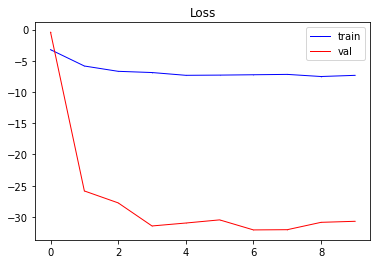

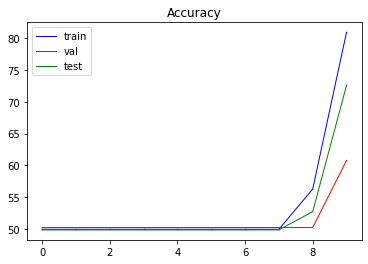

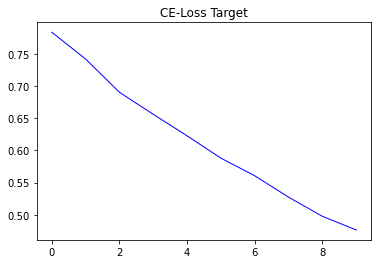

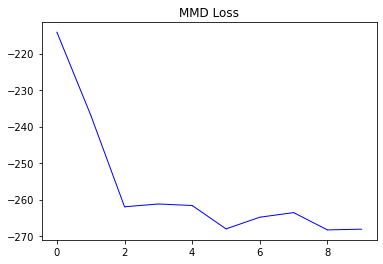

In [71]:
fig1 = plt.figure()
plt.title('Loss')
plt.plot(loss_list['train'], 'bo-', label = 'train', linewidth=1,markersize=0.1)
plt.plot(loss_list['val'], 'ro-', label = 'val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('no_mmd_loss_source')



fig2 = plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_list['train'], 'bo-', label = 'train', linewidth=1,markersize=0.1)
plt.plot(accuracy_list['val'], 'ro-', label = 'val', linewidth=1,markersize=0.1)
plt.plot(accuracy_list['test'], 'go-', label = 'test', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('no_mmd_accuracy_source')

fig3 = plt.figure()
plt.title('CE-Loss Target')
plt.plot(target_ce_loss_list, 'bo-', linewidth=1,markersize=0.1)
plt.show()
fig3.savefig('no_mmd_ce_loss_target')

fig4 = plt.figure()
plt.title('MMD Loss')
plt.plot(mmd_loss_list, 'bo-', linewidth=1,markersize=0.1)
plt.show()
fig4.savefig('no_mmd_mmd_loss')


In [41]:
with torch.no_grad():
    classes = ['class_0', 'class_1']
        
    #collect information about labels, predictions
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    n_class_samples_out = [0 for i in range(2)]
        
    #iterate through bateches in test_loader
    for i, (window, labels) in enumerate(target_loader["test"]):
        #make predictions for each batch
        outputs = model(window.float())
        outputs = classifier_layer_1(outputs)
        outputs = classifier_layer_2(outputs)
        outputs = classifier_layer_3(outputs)
        #for each element in batch check if prediction is correct and collect total and correct predictions and labels
        for i in range(len(labels)):
            label = labels[i]
            output = torch.argmax(outputs[i])
            print(output)
            if label == output:
                n_correct+=1
                n_class_correct[label]+=1
                    
            n_samples+=1
            n_class_samples[label]+=1
            n_class_samples_out[output]+=1
        else:
            break
        
    #calculate total accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
        
    #calculate class accuracy
    for i in range(4):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %') 


tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
Accuracy of the network: 96.875 %
Accuracy of class_0: 94.5945945945946 %
Accuracy of class_1: 100.0 %


IndexError: list index out of range